<a id='top'></a>

# NIRSpec MOS spectra backgrounds
---

This notebook assumes you've already extracted 1D spectra without background subtraction.

It figures out which spectra are backgrounds and can calculate a median master background for pipeline processing.

It also maps amplitude variation of the backgrounds across the field of view.

## 2. Observations <a id='observations'></a>
--- 
[GO 1433](https://www.stsci.edu/cgi-bin/get-proposal-info?observatory=JWST&id=1433) NIRSpec MOS PRISM observations:


Observation | ggsaa | shutters | exposures | exposure | total | total
:---: | :---: | :---: | :---: | :---: | :---: | :---:
Obs 21 | 03101<br>05101 | single-slitlet | 2 dithers | x 3210 s | = 6420 s | 1.8 hours 
Obs 23 | 04101        | 3-slitlet      | 3 nods    | x 2188 s | = 6564 s | 1.8 hours

## JWST filenames

https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

## 5. Import libraries <a id='import'></a>
---

In [1]:
import numpy as np
import os
home = os.path.expanduser("~")
from glob import glob
import json
# from IPython.display import JSON  # Nicer interactive output of JSON dictionaries
import inspect
from copy import deepcopy
from importlib import reload

In [2]:
import astropy
from astropy.io import fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack, unique
from astropy.stats import sigma_clip
print('astropy', astropy.__version__)

astropy 6.1.1


In [3]:
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

In [4]:
# ---------- Set CRDS environment variables ----------
# Define CRDS paths *before* importing crds
# otherwise you'll get CrdsDownloadError: 
# Failed caching mapping files: Configured for server-less mode.  
# Skipping JSON RPC 'get_mapping_names'

# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] :
# No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

# os.environ['CRDS_CONTEXT'] = 'jwst_1210.pmap'  # if you want to set a specific context
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
print(f'CRDS cache location: {os.environ["CRDS_PATH"]}')

CRDS cache location: /Users/dcoe/crds_cache


In [5]:
import crds
try:
    print(f"Current Operational CRDS Context = {crds.get_default_context()}")
except Exception:
    print('CRDS server not found (are you offline?)')

Current Operational CRDS Context = jwst_1256.pmap


In [6]:
# Import JWST pipeline

import jwst
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step
from jwst.associations import asn_from_list   # create association file

# Note if you're using a development version, it might not report the correct version number here.
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))

JWST Calibration Pipeline Version = 1.15.0


In [7]:
# To run faster on multiple cores in parallel
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  10


In [8]:
# To retrieve data from MAST
import astroquery
from astroquery.mast import Observations  # MAST
from astropy.table import Table, vstack, unique
print('astroquery version', astroquery.__version__)

astroquery version 0.4.7


In [9]:
# To plot and view results

import matplotlib  # as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch
from astropy.visualization import LogStretch, LinearStretch, ManualInterval
from astropy.stats import sigma_clip  # sigma_clipped_stats, SigmaClip

%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

In [10]:
# Define colormap
# cmap = 'viridis'
# bad_color = 1, 0.7, 0.7
# bad_color = 'r'  # color used for nan values
# cmap = matplotlib.colormaps[cmap]
# cmap.set_bad(bad_color, 1.)

# NIRSpec MOS pipeline helper libraries

In [11]:
import mos
import util
#reload(util)
from util import *

# Master Background Calculation

https://github.com/spacetelescope/jwebbinar_prep/blob/main/jwebbinar33/Master_Background_MOS_Demo.ipynb

### Load 1D spectra and map to common wavelength grid

In [12]:
output_dir = os.path.join('reprocess/master_background_calculation/spec3')
output_dir

'reprocess/master_background_calculation/spec3'

In [13]:
x1d_files = sorted(glob(os.path.join(output_dir, '*_x1d.fits')))
x1d_files = select_fits_headers(x1d_files, NOD_TYPE='NONE') # select single slitlet
len(x1d_files)

121

In [14]:
reload(util)
from util import *

### Define a common wavelength grid

In [15]:
# all wavelengths and separations
all_wavelengths = np.array([])
all_dlam = np.array([])

all_waves = []
all_fluxes = []
all_ra = []
all_dec = []

#for x1d_file in tqdm.tqdm(x1d_files, **tqdm_params):
for x1d_file in show_progress(x1d_files):
    x1d_model = datamodels.open(x1d_file)
    num_spectra = len(x1d_model.spec)
    for i_slit in range(num_spectra):
        x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
        #x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX    
        #x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
        x1d_flux    = x1d_model.spec[i_slit].spec_table.SURF_BRIGHT    
        x1d_fluxerr = x1d_model.spec[i_slit].spec_table.SB_ERROR

        #wavelengths = (x1d_wave[1:] + x1d_wave[:-1]) / 2.
        wavelengths = x1d_wave[:-1]  # what's the next dlam from here
        all_wavelengths = np.concatenate((all_wavelengths, wavelengths))
        dlam = x1d_wave[1:] - x1d_wave[:-1]  # or np.diff
        all_dlam = np.concatenate((all_dlam, dlam))

        all_waves.append(x1d_wave)
        all_fluxes.append(x1d_flux)
        ra  = x1d_model.spec[i_slit].slit_ra
        dec = x1d_model.spec[i_slit].slit_dec
        all_ra.append(ra)
        all_dec.append(dec)


100%|████████████████████| 121/121 [00:07<00:00, 16.0B/s] 


In [16]:
# Common wavelength grid
waves  = []
dlams = []

lam = min(all_wavelengths)
while lam < max(all_wavelengths):
    dlam = np.interp(lam, all_wavelengths, all_dlam)
    lam += dlam
    waves.append(lam)
    dlams.append(dlam)

### Interpolate spectra onto common wavelength grid

In [17]:
spectra = []
for i_spectrum, x1d_flux in enumerate(all_fluxes):
    x1d_wave = all_waves[i_spectrum]
    flux = np.interp(waves, x1d_wave, x1d_flux)
    spectra.append(flux)
    
spectra = np.array(spectra)

In [18]:
n_spectra, n_waves = spectra.shape
spectra.shape

(121, 428)

In [19]:
spectra_sums = np.nansum(spectra, axis=1)
i_sort = np.argsort(spectra_sums)
sorted_spectra = spectra[i_sort]

## Find background spectra: they're correlated

In [20]:
#n_spectra = len(sorted_spectra)
correlation_matrix = np.zeros((n_spectra, n_spectra))

for i in range(n_spectra):
    for j in range(i, n_spectra):
        if i == j:
            correlation = 1.0
        else:
            correlation, factor = mos.spectra_similarity(sorted_spectra[i], sorted_spectra[j])
        correlation_matrix[i, j] = correlation
        correlation_matrix[j, i] = correlation

In [21]:
smoothed_matrix = gaussian_filter(correlation_matrix, sigma=5)
    
# Find the peak (maximum value) in the smoothed 2D matrix
#max_value = np.max(smoothed_matrix)
max_position = np.unravel_index(np.argmax(smoothed_matrix), smoothed_matrix.shape)
i_peak = max_position[0]  # e.g., (31, 31) symmetric
i_similar = i_sort[i_peak]

single_background_spectrum = spectra[i_similar]

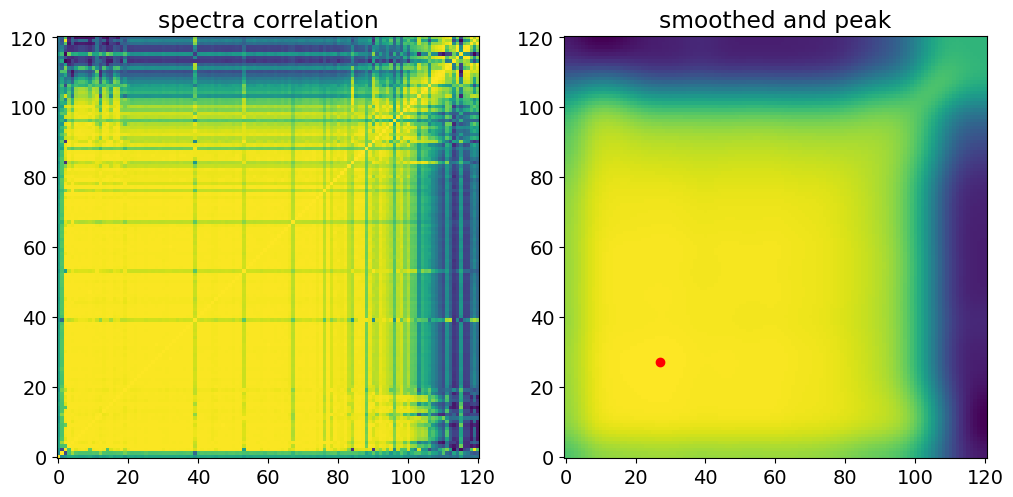

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(correlation_matrix, origin='lower')
axs[0].set_title('spectra correlation')
axs[1].imshow(smoothed_matrix,    origin='lower')
axs[1].set_title('smoothed and peak')
axs[1].plot(i_peak, i_peak, 'ro')

In [23]:
#cmap_name = 'viridis'
#cmap = plt.get_cmap(cmap_name)
#vmin, vmax = 0.9, 1
#norm = Normalize(vmin=vmin, vmax=vmax)
cmap = None

2024-08-05 11:59:30,109 - stpipe - WARNING - /Users/dcoe/macs0647/Cycle1/NIRSpec/util.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-08-05 11:59:30,109 - stpipe - WARNING -   ax.legend()  # generate it to update
2024-08-05 11:59:30,110 - stpipe - WARNING - 
2024-08-05 11:59:30,402 - stpipe - WARNING - /var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26415/533407057.py:25: RuntimeWarning: All-NaN slice encountered
2024-08-05 11:59:30,403 - stpipe - WARNING -   background_median = np.nanmedian(background_spectra, axis=0)
2024-08-05 11:59:30,403 - stpipe - WARNING - 
2024-08-05 11:59:30,406 - stpipe - WARNING - /var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26415/533407057.py:29: RuntimeWarning: All-NaN slice encountered
2024-08-05 11:59:30,406 - stpipe - WARNING -   normalized_background_median = np.nanmedian(normalized_background_sp

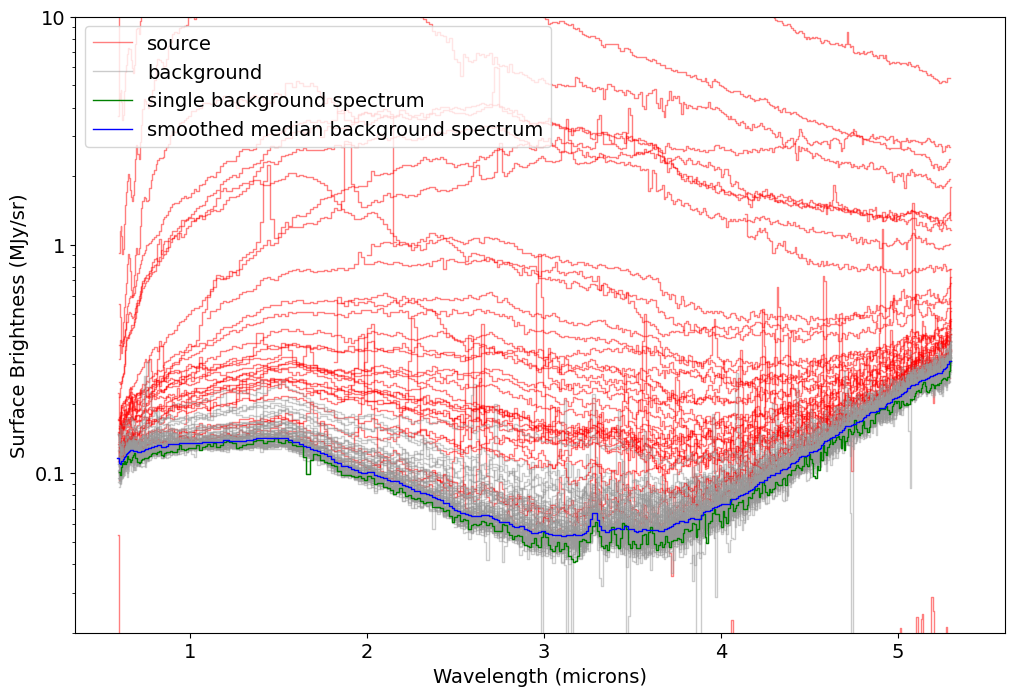

In [24]:
background_spectra = []
normalized_background_spectra = []

fig, ax = plt.subplots(1, 1, figsize=(12,8))
#fig, ax = plt.subplots()

for i_slit in range(n_spectra):
    spectrum = spectra[i_slit]
    correlation, factor = mos.spectra_similarity(spectrum, single_background_spectrum)
    if correlation > 0.9:
        label = label_once_in_legend('background', ax)
        ax.step(waves, spectrum,          lw=1, alpha=0.5, color='0.60', label=label)
        background_spectra.append(spectrum)

        label = label_once_in_legend('background normalized', ax)
        #ax.step(waves, spectrum / factor, lw=1, alpha=0.5, color='r', label=label)        
        normalized_background_spectra.append(spectrum / factor)
    else:
        label = label_once_in_legend('source', ax)
        ax.step(waves, spectrum,          lw=1, alpha=0.5, color='r', label=label)

label = 'single background spectrum'
ax.step(waves, single_background_spectrum, lw=1, alpha=1, color='g', label=label)

background_median = np.nanmedian(background_spectra, axis=0)
smooth_background_median = medfilt(background_median, kernel_size=3)

normalized_background_spectra = np.array(normalized_background_spectra)
normalized_background_median = np.nanmedian(normalized_background_spectra, axis=0)
smooth_normalized_background_median = medfilt(normalized_background_median, kernel_size=3)

label = 'smoothed median background spectrum'
ax.step(waves, smooth_background_median, lw=1, alpha=1, color='b', label=label)

#label = 'median normalized background spectrum'
#ax.step(waves, smooth_normalized_background_median, lw=1, alpha=1, color='k', label=label)

plt.semilogy()
# plt.ylim(1e-7, 3e-4)  # FLUX
plt.ylim(0.02, 10)  # SURF_BRIGHT
#plt.xlim(0.5, 5.4)
plt.legend()

plt.xlabel('Wavelength (microns)')
plt.ylabel('Surface Brightness (MJy/sr)')
    
# Set the y-axis formatter to show as integers or decimals
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.get_major_formatter().set_useOffset(False)
#ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '%g' % x))

2024-08-05 14:38:31,586 - stpipe - WARNING - /var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_26415/1848860959.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-08-05 14:38:31,586 - stpipe - WARNING -   plt.legend()
2024-08-05 14:38:31,587 - stpipe - WARNING - 


Text(0.5, 1.0, 'Background Spectra')

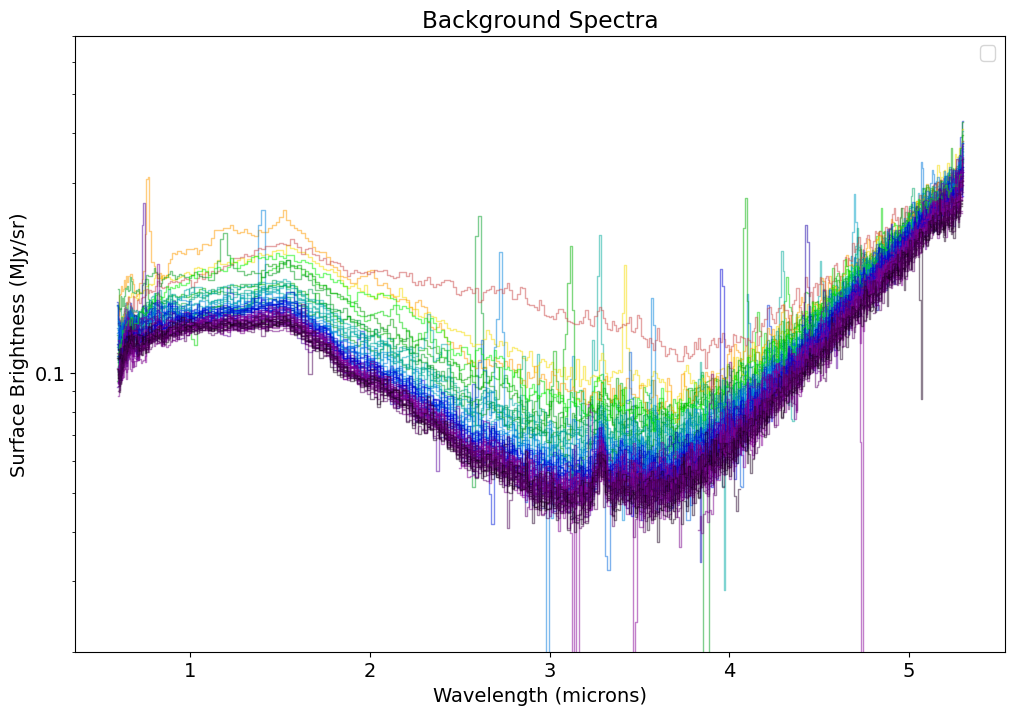

In [106]:
cmap = 'nipy_spectral'
cm = plt.get_cmap(cmap)
cNorm  = matplotlib.colors.Normalize(vmin=0.98, vmax=1.62)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(1, 1, figsize=(12,8))

for i_slit in range(n_spectra):
    spectrum = spectra[i_slit]
    correlation, factor = mos.spectra_similarity(spectrum, single_background_spectrum)
    if correlation > 0.9:
        color = scalarMap.to_rgba(factor)
        ax.step(waves, spectrum, lw=1, alpha=0.5, color=color)

label = 'smoothed median background spectrum'
#ax.step(waves, smooth_background_median, lw=1, alpha=1, color='b', label=label)

plt.semilogy()
plt.ylim(0.02, 0.7)  # SURF_BRIGHT
plt.legend()

plt.xlabel('Wavelength (microns)')
plt.ylabel('Surface Brightness (MJy/sr)')
    
# Set the y-axis formatter to show as integers or decimals
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.get_major_formatter().set_useOffset(False)
#ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '%g' % x))
plt.title('Background Spectra')

0.9879894406407539 1.597826337972303


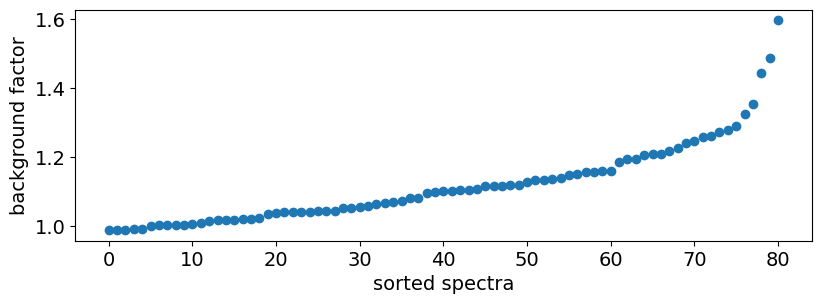

In [104]:
factors = []
for i_slit in range(n_spectra):
    spectrum = spectra[i_slit]
    correlation, factor = mos.spectra_similarity(spectrum, single_background_spectrum)
    #print('%3d  %5.2f  %5.2f' % (i_slit, correlation, factor))
    if correlation > 0.9:
        factors.append(factor)

fig = plt.figure(figsize=(9.5, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(factors), 'o')
plt.xlabel('sorted spectra')
plt.ylabel('background factor')
print(min(factors), max(factors))

# Plot background variation across the field of view

### Show the NIRSpec FOV

https://pypi.org/project/JWST-FOV-plotter

Pablo Arrabal-Haro

`pip install --upgrade JWST_FOV_plotter`

2024-08-05 14:36:37,432 - stpipe - WARNING - /Users/dcoe/miniconda3/envs/jwst_1.15.0/lib/python3.11/site-packages/JWST_FOV_plotter/apertures_selecter.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '#228a44' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
2024-08-05 14:36:37,432 - stpipe - WARNING -   fovs.loc[fovs.Aperture == ap, 'plot_color'] = col


2024-08-05 14:36:37,433 - stpipe - WARNING - 


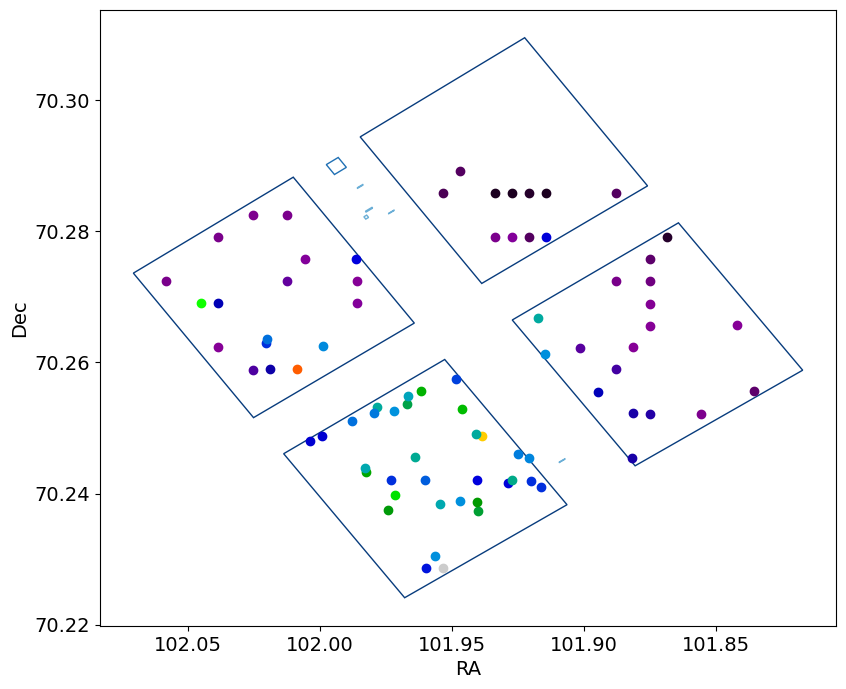

<Figure size 640x480 with 0 Axes>

In [100]:
cmap = 'nipy_spectral'
#cmap = 'inferno'
cm = plt.get_cmap(cmap)
#cNorm  = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
#cNorm  = matplotlib.colors.Normalize(vmin=0.8, vmax=1.3)
cNorm  = matplotlib.colors.Normalize(vmin=0.98, vmax=1.6)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(9.5, 8))
ax = fig.add_subplot(111)
#ax.set_aspect(1)

# NIRSpec FOV
obs_ra = 101.94430 # Observed RA
obs_dec = 70.26605  # Observation Dec
roll_APA = 305.0601 # APA angle of the reference instrument in degrees.
#roll_APA = 258.1712  # APA angle of the reference instrument in degrees.
plot_JWST_FOVs(obs_ra, obs_dec, rot=roll_APA, ref_instr='NIRSpec', instr_to_plot=['NIRSpec'])


for i_slit in range(n_spectra):
    spectrum = spectra[i_slit]
    correlation, factor = mos.spectra_similarity(spectrum, single_background_spectrum)
    if correlation > 0.9:
        #print('%3d  %5.2f  %5.2f' % (i_slit, correlation, factor))

        color = scalarMap.to_rgba(factor)
        plt.plot(all_ra[i_slit], all_dec[i_slit], 'o', color=color)

        #print('%3d  %5.2f  %5.2f  %g  %g' % (i_slit, correlation, factor, all_ra[i_slit], all_dec[i_slit]))

plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
plt.savefig('backgrounds_map.png')

# Median background

In [ ]:
len(smooth_background_median)

In [ ]:
master_background_file = 'master_background_x1d.fits'
#output_dir = 'reprocess/master_background_calculation'
master_background_file = os.path.join(output_dir, master_background_file)
master_background_file

In [ ]:
# Compress to not nan or zero
good = ~np.isnan(smooth_background_median) & (smooth_background_median != 0)
background_wave = np.compress(good, waves)
background_flux = np.compress(good, smooth_background_median)
background_wave.shape, background_flux.shape, len(smooth_background_median)#, np.sum(good)

In [ ]:
# Save Master Background
#waves, smooth_background_median
with fits.open(x1d_file) as hdu_list:
    primary_hdu = fits.PrimaryHDU(header=hdu_list[0].header)
    columns = hdu_list[1].columns
    background_table = Table(np.zeros((len(background_wave), len(columns)), dtype=np.float32), names=columns.names)

    # Set all values in the table to NaN where they were originally 0.
    #for colname in background_table.colnames:
    #    if colname != 'DQ':
    #        background_table[colname] = np.where(background_table[colname] == 0, np.nan, 
    #                                             background_table[colname])

    # Assign the wavelength, surface brightness, and error to the empty table.
    background_table['WAVELENGTH']  = background_wave
    background_table['SURF_BRIGHT'] = background_flux
    # hdu_table['FLUX_ERROR'] = standard_error_of_median

    background_hdu = fits.BinTableHDU(background_table, header=hdu_list[1].header)

    # Combine the primary HDU and the new BinTableHDU into an HDUList.
    hdu_list_out = fits.HDUList([primary_hdu, background_hdu])

    # Write the HDUList to a FITS file.
    with open(master_background_file, 'wb') as fobj:
        hdu_list_out.writeto(fobj, overwrite=True)
    # hdul_out.writeto(output_file, overwrite=True)
    
master_background_file

### Check the output

Note we only added `WAVELENGTH` and `SURF_BRIGHT`. That's all the Master Background subtraction step needs.

In [ ]:
background_hdu_list = fits.open(master_background_file)
background_hdu_list.info()

In [ ]:
#Table(background_hdu.data[10:-10])
Table(background_hdu_list['EXTRACT1D'].data)

# About this notebook <a id='about'></a>

**Authors:** Dan Coe (dcoe@stsci.edu) and Kayli Glidic with contributions from Pablo Arrabal Haro

**Updated:** July 2024 running JWST pipeline version 1.15.0 with CRDS context jwst_1252.pmap

---

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

[Top of Page](#top)   
